In [1]:
import nengo
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as st
from nengo.spa import Vocabulary
from nengo.dists import UniformHypersphere
from nengo.dists import Choice
% matplotlib inline

max_age = 120

x1 = 35   
x2 = 5
x3 = 25
x4 = 55
x5 = 65

thetas = np.linspace(start=1, stop=max_age, num=max_age)   # all possible values of theta (from 1 to 120)

#################################################### likelihood #######################################

# Compute the likelihood of observing the iid data (x1,x2,x3,x4,x5)
likelihood1 = [1/p for p in thetas]  #  p(X/theta)
likelihood1[0:x1-1] = [0]*(x1-1)  # likelihood is 1/theta for theta >= x and 0 otherwise

likelihood2 = [1/p for p in thetas]  
likelihood2[0:x2-1] = [0]*(x2-1)

likelihood3 = [1/p for p in thetas]  
likelihood3[0:x3-1] = [0]*(x3-1)

likelihood4 = [1/p for p in thetas]  
likelihood4[0:x4-1] = [0]*(x4-1)

likelihood5 = [1/p for p in thetas]  
likelihood5[0:x5-1] = [0]*(x5-1)

likelihood = np.multiply(np.multiply(likelihood1, likelihood2), np.multiply(likelihood3, likelihood4))
likelihood = np.multiply(likelihood, likelihood5)   #  p(X/theta)
holder = np.zeros((1,len(likelihood)))    # change shape of likelihood from (120,) to (1,120)
holder[0,:] = likelihood
likelihood = holder

########################################################################################################

# P(theta/alpha) for all values of theta and alpha
# declare a matrix which will store p_theta along columns for each given alpha
# theta varies along rows, and alpha varies along columns
p_matrix = np.zeros((len(thetas), max_age))
for x in np.arange(1,max_age+1,1):
    p_theta = [(st.norm.pdf(p, loc=x, scale=16)) for p in thetas]
    p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)
    p_matrix[:, x-1] = p_theta
    
########################################################################################################

#Normalize both likelihood and p_matrxi for accurate representation in neurons
likelihood = likelihood/np.sum(likelihood)
p_matrix = p_matrix/np.sum(p_matrix)

In [2]:
# Computational alpha_hat for comparison
marginpost_set = np.dot(likelihood, p_matrix)   # this will be a list of dimentions (1 x max_age)
#pick the max value and find the corresponding alpha
alpha_hat = np.argmax(marginpost_set) + 1
print "Computational alpha_hat: ", alpha_hat
print likelihood.shape
print p_matrix.shape

#print likelihood
#print p_matrix

Computational alpha_hat:  76
(1, 120)
(120, 120)


In [3]:
# Now represent the likelihood i.e., P(X/theta) and P(theta/alpha) in neurons
# And then compute P(X/alpha) by marginalizing out theta for each alpha

num_neurons = 50
dim = max_age

# Values should stay within the range (-radius,radius)
radius = 1

rng = np.random.RandomState(12) 
num_samples = 4000

model = nengo.Network(seed=123)
with model:  
    
    # define eval points to only represent positive values
    encoders = UniformHypersphere(surface=True).sample(num_neurons, 1, rng=rng)
    eval_points = rng.uniform(0, 1, size=(num_samples, 1))
    
    # Make 2 EnsembleArrays to store the input
    lik = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=likelihood.size, 
                                radius=radius, encoders=encoders, eval_points=eval_points, 
                                n_eval_points=eval_points.shape[0])
    prior = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=p_matrix.size, 
                                radius=radius, encoders=encoders, eval_points=eval_points, 
                                n_eval_points=eval_points.shape[0])
    
    # connect inputs to them so we can set their value
    likelihood_in = nengo.Node(output=likelihood.ravel())    # p(X/theta): matrix of dimension (1, 120)
    prior_in = nengo.Node(output=p_matrix.ravel())   # p(theta/alpha): matrix of dimension (120, 120)
    nengo.Connection(likelihood_in, lik.input)
    nengo.Connection(prior_in, prior.input)
    
   
    
    # The C matix is composed of populations that each contain
    # one element of 'lik' and one element of 'prior'.
    # These elements will be multiplied together in the next step.
    
    # The appropriate encoders make the multiplication more accurate
    #eval_points = rng.uniform(0, 1, size=(50, 2))
    C = nengo.networks.EnsembleArray(n_neurons=num_neurons,
                                     n_ensembles=likelihood.size * p_matrix.shape[1],
                                     ens_dimensions=2,
                                     radius=1.5 * radius,
                                     encoders=Choice([[1, 1], [-1, 1], [1, -1], [-1, -1]]))
                                     
    # Now compute the products and do the appropriate summing
    #eval_points = rng.uniform(0, 1, size=(50, 1))
    D = nengo.networks.EnsembleArray(n_neurons=num_neurons,
                                     n_ensembles=likelihood.shape[0] * p_matrix.shape[1],
                                     radius=radius)

                                     

In [4]:
# Determine the transformation matrices to get the correct pairwise
# products computed.

transformA = np.zeros((C.dimensions, likelihood.size))
transformB = np.zeros((C.dimensions, p_matrix.size))

for i in range(likelihood.shape[0]):
    for j in range(likelihood.shape[1]):
        for k in range(p_matrix.shape[1]):
            tmp = (j + k * likelihood.shape[1] + i * p_matrix.size)
            transformA[tmp * 2][j + i * likelihood.shape[1]] = 1
            transformB[tmp * 2 + 1][k + j * p_matrix.shape[1]] = 1
            
print("Likelihood->C")
print(transformA)
print("p_matrix->C")
print(transformB)


def product(x):
    return x[0] * x[1]

# The mapping for this transformation (C->D) is much easier, since we want to
# combine D2 pairs of elements (we sum D2 products together)
transformC = np.zeros((D.dimensions, p_matrix.size))
for i in range(p_matrix.size):
    transformC[i // p_matrix.shape[0]][i] = 1
print("C->D")
print(transformC)

Likelihood->C
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
p_matrix->C
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
C->D
[[ 1.  1.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  1.  1.]]


In [5]:
with model:
    nengo.Connection(lik.output, C.input, transform=transformA)
    nengo.Connection(prior.output, C.input, transform=transformB)
    
    prod = C.add_output("product", product)
    nengo.Connection(prod, D.input, transform=transformC)
    

In [6]:
with model:
    # probes
    lik_p = nengo.Probe(lik.output, sample_every=0.01, synapse=0.01)
    prior_p = nengo.Probe(prior.output, sample_every=0.01, synapse=0.01)
    C_probe = nengo.Probe(C.output, sample_every=0.01, synapse=0.01)
    D_probe = nengo.Probe(D.output, sample_every=0.01, synapse=0.01)


In [7]:
sim = nengo.Simulator(model)  # Create the simulator
sim.run(1.0)

Building finished in 0:06:57.                                                   
Simulating finished in 2:13:58.                                                 


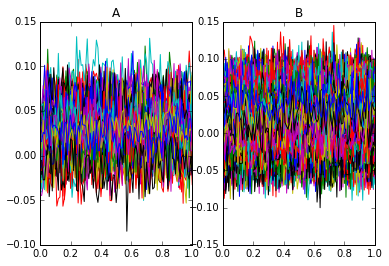

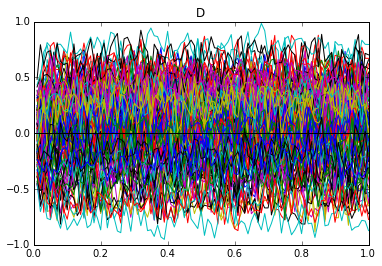

In [8]:
plt.subplot(1, 2, 1)
plt.title('A')
plt.plot(sim.trange(dt=0.01), sim.data[lik_p])
plt.subplot(1, 2, 2)
plt.title('B')
plt.plot(sim.trange(dt=0.01), sim.data[prior_p]);

plt.figure()
plt.plot(sim.trange(dt=0.01), sim.data[D_probe])
for d in np.dot(likelihood, p_matrix).flatten():
    plt.axhline(d, color='k')
plt.title("D");

In [33]:
D = sim.data[D_probe]
arr = D[len(D)-40]
print arr
print np.argmax(arr)

[ 0.00874929  0.26208713 -0.07975781 -0.02128538 -0.28908904 -0.04071847
 -0.22245766 -0.26585775  0.0528745   0.21387927 -0.1886025  -0.45379898
  0.14048166 -0.62556969  0.35108319 -0.03361284  0.19106685  0.73308325
  0.13330794 -0.14691959  0.02593039  0.10912809 -0.12137439 -0.19005571
  0.27748759 -0.0988927  -0.66108007  0.61863941 -0.0819578  -0.44657654
  0.11272754  0.41788807 -0.63661021  0.40978712  0.46603763 -0.73366088
  0.37755965 -0.73976481 -0.01457912 -0.16269719  0.32639333 -0.06470716
  0.67045998  0.36078352  0.22403282  0.32853111  0.07209289 -0.24298489
 -0.06070658  0.16513206 -0.57823005  0.27565102  0.48790144  0.14681502
  0.40703975 -0.12160499  0.20076801  0.1727572   0.36042266 -0.10550814
 -0.12808131 -0.79473862 -0.63579196  0.10294457  0.13590289  0.44150468
  0.19032901  0.34927616  0.30946744 -0.71073251 -0.03380715 -0.27186928
  0.84174894  0.46410797 -0.48934306  0.60859176  0.13217941  0.20510825
  0.2947346   0.55668892 -0.82779822 -0.32004936  0

In [28]:
#print likelihood*10
print p_matrix*np.power(10,10)
print np.max(likelihood)
print np.min(likelihood)

print np.max(p_matrix)*np.power(10,10)
print np.min(p_matrix)*np.power(10,10)

print np.max(marginpost_set)
print np.min(marginpost_set)

scaled = marginpost_set
print scaled
prediction = np.argmax(scaled)
print prediction

[[  4.05455297e+06   3.85923820e+06   3.66782388e+06 ...,   9.04402239e-06
    5.97827190e-06   3.94582647e-06]
 [  4.04664165e+06   3.86678314e+06   3.68937813e+06 ...,   1.42560611e-05
    9.46041189e-06   6.26857499e-06]
 [  4.02300018e+06   3.85923820e+06   3.69659098e+06 ...,   2.23841704e-05
    1.49124144e-05   9.91980665e-06]
 ..., 
 [  9.91980665e-06   1.49124144e-05   2.23841704e-05 ...,   3.69659098e+06
    3.85923820e+06   4.02300018e+06]
 [  6.26857499e-06   9.46041189e-06   1.42560611e-05 ...,   3.68937813e+06
    3.86678314e+06   4.04664165e+06]
 [  3.94582647e-06   5.97827190e-06   9.04402239e-06 ...,   3.66782388e+06
    3.85923820e+06   4.05455297e+06]]
0.0650166409933
0.0
4054552.96628
3.94582646751e-06
0.000164951749959
3.10499731444e-08
[[  3.10499731e-08   3.83161189e-08   4.72177016e-08   5.81042324e-08
    7.13947247e-08   8.75901077e-08   1.07287485e-07   1.31196419e-07
    1.60157416e-07   1.95162768e-07   2.37379875e-07   2.88177155e-07
    3.49152569e-07   4

In [ ]:
print likelihood
print np.sum(likelihood)
print np.sum(p_matrix)
likelihood = likelihood/sum(likelihood)
p_matrix = p_matrix/sum(p_matrix)
marginpost_set = np.dot(likelihood, p_matrix)
print np.argmax(marginpost_set)